In [1]:
import os
import torch
from torchvision.transforms import v2
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from ultralytics import YOLO

import cv2
from PIL import Image
from tqdm import tqdm
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np



## Helpers

In [2]:
ID_TO_LABEL = {
    0:'Mask',
    1: 'can',
    2: 'cellphone',
    3: 'electronics',
    4: 'gbottle',
    5: 'glove',
    6: 'metal',
    7: 'misc',
    8: 'net',
    9: 'pbag',
    10: 'pbottle',
    11: 'plastic',
    12: 'rod',
    13: 'sunglasses',
    14: 'tire'
}

In [3]:
def plot_rcnn_images(images, results, threshold: int = 0.5):
    # Plot the images with predictions
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i, (image, result) in enumerate(zip(images, results)):
        img = np.array(Image.fromarray(image.mul(255).permute(1, 2, 0).byte().cpu().numpy()))
        boxes = result["boxes"]
        labels = result["labels"]
        confidences = result["scores"]

        axes[i].imshow(img)

        for box, label, conf in zip(boxes, labels, confidences):
            if conf < threshold:
                continue
            
            # plot the bounding box
            x1, y1, x2, y2 = box
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
            axes[i].add_patch(rect)
            axes[i].text(x1, y1 - 10, f'{ID_TO_LABEL.get(int(label), "unknown")} {conf:.2f}', color='red')
            axes[i].axis('off')


    plt.tight_layout()
    plt.show()

def collate(batch):

    images = [batch_item[0] for batch_item in batch]
    images = torch.stack(images, dim=0)
    targets = [batch_item[1] for batch_item in batch]
    return images, targets

def get_dataset(data_path: str | os.PathLike[str], batch_size: int = 2) -> torch.utils.data.DataLoader:

    dataset = GarbageDataset(
        root=data_path,
        # transforms=v2.Compose([v2.ToDtype(torch.float, scale=True), v2.ToTensor()])
        transforms=v2.Compose([v2.ToDtype(torch.float, scale=True)])
    )
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)

    return loader

In [4]:
class GarbageDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "labels"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        box_path = os.path.join(self.root, "labels", self.masks[idx])
        img = read_image(img_path)
        
        
        # # first id is the background, so remove it
        # obj_ids = obj_ids[1:]
        # num_objs = len(obj_ids)

        
        # get bounding box coordinates for each mask
        image_width, image_height = img.shape[2], img.shape[1]
        ids = []
        boxes = []
        
        with open(box_path, "r") as f:
            for line in f.readlines():
                obj = line.split()
                ids.append(int(obj[0]))
                # temp = list(map(float, obj[1:]))
                # temp[2] += temp[0]
                # temp[3] += temp[1]
                # boxes.append(temp)
                
                temp = list(map(float, obj[1:]))
                x_center, y_center, width, height = temp

                # Convert to pixel coordinates
                x_center_pixel = x_center * image_width
                y_center_pixel = y_center * image_height
                width_pixel = width * image_width
                height_pixel = height * image_height

                # Calculate (xmin, ymin, xmax, ymax)
                xmin = int(x_center_pixel - (width_pixel / 2))
                ymin = int(y_center_pixel - (height_pixel / 2))
                xmax = int(x_center_pixel + (width_pixel / 2))
                ymax = int(y_center_pixel + (height_pixel / 2))

                boxes.append([xmin, ymin, xmax, ymax])
                
                

        # image_id = idx
        try:
          np_boxes = torch.as_tensor(boxes, dtype=torch.float32)
          area = (np_boxes[:, 3] - np_boxes[:, 1]) * (np_boxes[:, 2] - np_boxes[:, 0])
        except IndexError:
          return self.__getitem__(idx + 1)
        is_crowd = torch.zeros((len(boxes),), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = torch.as_tensor(img, dtype=torch.float16) / 256

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=F.get_size(img))
        target["labels"] = torch.tensor(ids)
        # target["image_id"] = idx
        # target["area"] = area
        # target["iscrowd"] = is_crowd


        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

## YOLO

In [5]:
# On macOS M processors, use MPS if available
# if torch.backends.mps.is_available():
#     device = torch.device("mps")

In [6]:
def plot_yolo_results(model, dataset: str, batch_size: int = 4):
    assert dataset in ["train", "test", "valid"], "Invalid dataset name"
    images_dir = os.path.join(f"datasets/{dataset}/images/")
    dataset_images = [os.path.join(images_dir, name) for name in os.listdir(images_dir)]

    results = model(dataset_images[:batch_size])  # return a list of Results objects

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid
    axes = axes.flatten()

    for i, (result, ax) in enumerate(zip(results, axes)):
        result_img = result.plot()  # Draw detections on the image
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        ax.imshow(result_img)
        ax.set_title(f"Image {i+1}")
        ax.axis("off")


In [7]:
def load_best_yolo_model():
    best_path = "yolo_best_kaggle/results/runs/detect/train/weights/best.pt"
    if os.path.exists(best_path):
      return YOLO(best_path)

    return  YOLO("yolo11n.pt") # Pre-trained Nano model

# UNCOMMENT FOR TRAINING
# result = yolo.train(data="datasets/data.yaml", epochs=10, imgsz=640, batch=16, cache=True)

yolo = load_best_yolo_model()


0: 640x640 1 net, 44.8ms
1: 640x640 1 pbottle, 44.8ms
2: 640x640 1 misc, 44.8ms
3: 640x640 1 tire, 44.8ms
Speed: 3.0ms preprocess, 44.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


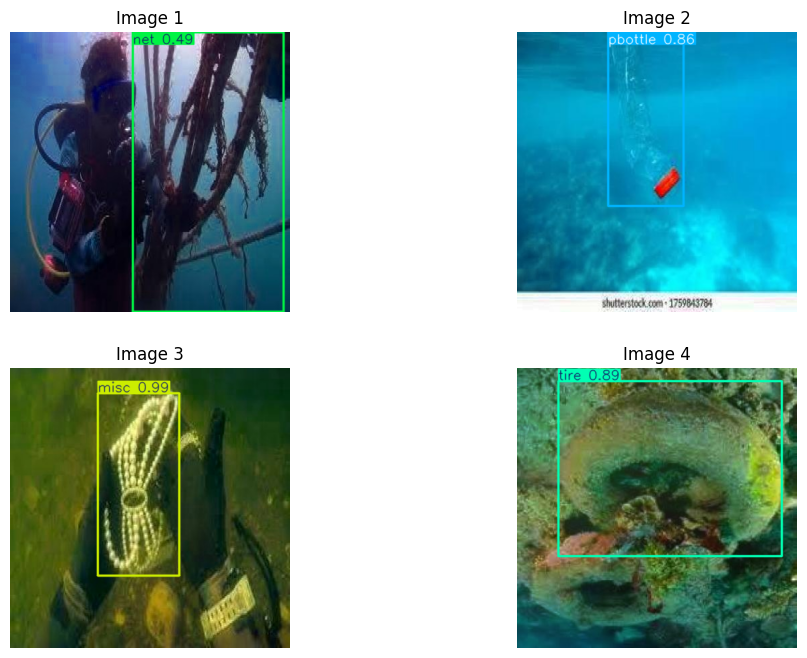

In [8]:
image_path = './datasets/test/images/GettyImageskl-1227891345-1000x667_jpg.rf.b1b21e076c5e516af46499d92e4d57d8.jpg'
# Perform inference
# results = model.predict(source=image_path, conf=0.1, save=True)
plot_yolo_results(model=yolo, dataset="valid", batch_size=4)

## R-CNN

In [9]:
import os
import torch
from torchvision.transforms import v2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.transforms import functional as F
from PIL import Image
from tqdm import tqdm

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

# model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT, trainable_backbone_layers=1, max_size=160)
model = fasterrcnn_resnet50_fpn(weights=None, trainable_backbone_layers=1, max_size=80)

In [10]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F




In [11]:
def collate(batch):
    
    images = [batch_item[0] for batch_item in batch]
    images = torch.stack(images, dim=0)
    targets = [batch_item[1] for batch_item in batch]
    return images, targets

def get_dataset(data_path: str | os.PathLike[str], batch_size: int = 2) -> torch.utils.data.DataLoader:

    dataset = GarbageDataset(
        root=data_path, 
        # transforms=v2.Compose([v2.ToDtype(torch.float, scale=True), v2.ToTensor()])
        transforms=v2.Compose([v2.ToDtype(torch.float, scale=True)])
    )
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=True)
    
    return loader

In [12]:


class RCNN:
    def __init__(self, model, device: str = "cpu", checkpoint_dir: str = "checkpoints"):
        self.device = device
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        self.checkpoint_dir = checkpoint_dir
        os.makedirs(self.checkpoint_dir, exist_ok=True)  # Create checkpoint directory if it doesn't exist

    def train(self, data_loader, num_epochs: int = 10):
        self.model.train()
        self.model.to(self.device)

        best_loss = float("inf")  # Track the best validation loss

        for epoch in range(num_epochs):
            with tqdm(total=len(data_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
                for images, targets in data_loader:
                    images = [img.to(self.device) for img in images]
                    targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

                    loss_dict = self.model(images, targets)
                    total_loss = sum(loss for loss in loss_dict.values())
                    loss_dict = {
                        "loss_classifier": loss_dict["loss_classifier"].item(),
                        "loss_box_reg": loss_dict["loss_box_reg"].item(),
                    }

                    # Backpropagation
                    self.optimizer.zero_grad()
                    total_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)  # Gradient clipping
                    self.optimizer.step()

                    # Update progress bar
                    pbar.set_postfix(loss_dict)
                    pbar.update(1)


                    # Save the best model after each batch
                    if total_loss.item() < best_loss:
                        best_loss = total_loss.item()
                        self._save_checkpoint("best_model", epoch + 1, best_loss)
                        print(f"New best model saved at epoch {epoch + 1} with loss: {best_loss}")

        print("Training completed.")

    def _get_checkpoint_path(self, name) -> str:
        
        date_path = dt.datetime.now().strftime("%Y%m%d")
        ch_dir = os.path.join("RCNN", date_path)
        os.makedirs(ch_dir, exist_ok=True)
        ch_path = os.path.join(ch_dir, f"{name}.pth")

        return ch_path

    def _save_checkpoint(self, name: str, epoch: int, loss: float):
        """Save model checkpoint."""
        path = self._get_checkpoint_path(name)

        torch.save({
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "loss": loss,
        }, path)
        print(f"Checkpoint saved to {path}")

    def load_checkpoint(self, path: str):
        """Load model checkpoint."""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        epoch = checkpoint["epoch"]
        loss = checkpoint["loss"]
        print(f"Loaded checkpoint from epoch {epoch} with loss: {loss}")
        return epoch, loss

    def generate_predictions(self, data_loader, batch_size: int = 4, threshold: float = 0.5):
        self.model.eval()

        # Get images
        test_images, test_targets = next(iter(data_loader))
        test_images = [img.to(self.device) for img in test_images]
        results = self.model(test_images)
            
        return test_images, results

In [13]:
train_loader = get_dataset("datasets/train", batch_size=2)
rcnn = RCNN(model, device='cpu')

# TRAIN THE MODEL
# rcnn.train(train_loader, num_epochs=2)

# load checkpoint
rcnn.load_checkpoint("RCNN/20250130/best_model.pth")


Loaded checkpoint from epoch 2 with loss: 0.025640767067670822


(2, 0.025640767067670822)

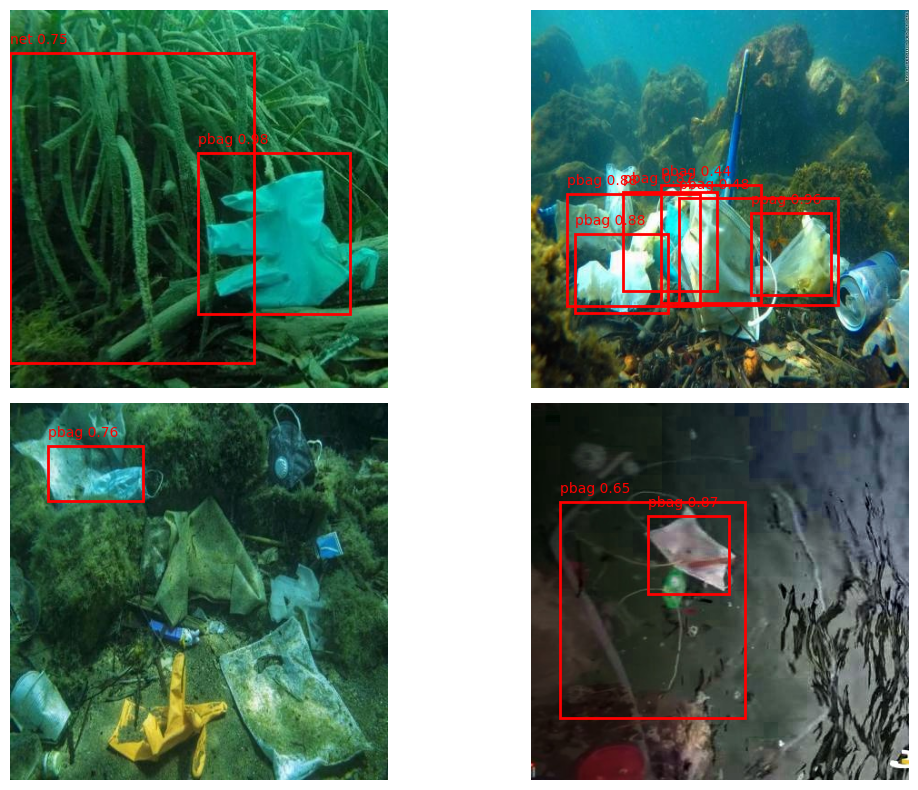

In [14]:
test_loader = get_dataset("datasets/test", batch_size=4)
images, results = rcnn.generate_predictions(test_loader)
plot_rcnn_images(images, results, threshold=0.4)

## Porównanie

In [121]:
# Assuming you have the ground truth data and model predictions stored in variables y_true and y_pred respectively
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def calulate_mean_average_precision(model, loader):

    # compute mAP
    mAP = MeanAveragePrecision(iou_thresholds=[0.2])
    maps = []
    with tqdm(total=len(loader), desc="Computing mAP", unit="batch") as pbar:
        for images, labels in loader:
            # images, labels = next(iter(loader))
            labels = [lab | {"boxes": lab["boxes"].real} for lab in labels]

            y_pred = model(images);
            if not isinstance(y_pred[0], dict):
                y_pred = [
                    {
                        "boxes": res.boxes.xyxy,
                        "labels": torch.tensor(list(map(int, res.boxes.cls))),
                        "scores": res.boxes.conf,
                    }
                    for res in y_pred
                ]   
            mAP.update(y_pred, labels)
            result = mAP.compute()
            maps.append(result["map"].item())
            pbar.update(1)
        
    
    return sum(maps) / len(maps)

In [125]:
test_loader = get_dataset("datasets/test", batch_size=20)
yolo_map = calulate_mean_average_precision(model=rcnn.model, loader=test_loader)
print(f"Mean Average Precision (mAP) for YOLO: {yolo_map:.3f}")

Computing mAP: 100%|██████████| 25/25 [01:26<00:00,  3.45s/batch]

Mean Average Precision (mAP) for YOLO: 0.1214376449584961


In [ ]:
test_loader = get_dataset("datasets/test", batch_size=20)
rcnn_map = calulate_mean_average_precision(model=yolo, loader=test_loader)
print(f"Mean Average Precision (mAP) for RCNN: {rcnn_map:.3f}")

Computing mAP:   0%|          | 0/25 [00:00<?, ?batch/s]


0: 416x416 1 glove, 1 net, 78.1ms
1: 416x416 1 Mask, 1 pbottle, 78.1ms
2: 416x416 2 Masks, 1 pbag, 2 pbottles, 78.1ms
3: 416x416 1 Mask, 78.1ms
4: 416x416 1 gbottle, 1 pbag, 78.1ms
5: 416x416 1 Mask, 1 glove, 78.1ms
6: 416x416 (no detections), 78.1ms
7: 416x416 1 Mask, 78.1ms
8: 416x416 1 pbag, 78.1ms
9: 416x416 1 Mask, 2 gloves, 1 pbag, 78.1ms
10: 416x416 1 Mask, 78.1ms
11: 416x416 1 Mask, 78.1ms
12: 416x416 2 gloves, 78.1ms
13: 416x416 2 gloves, 78.1ms
14: 416x416 2 gloves, 78.1ms
15: 416x416 2 gloves, 78.1ms
16: 416x416 3 gloves, 78.1ms
17: 416x416 2 gloves, 78.1ms
18: 416x416 1 pbag, 78.1ms
19: 416x416 1 glove, 1 pbag, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:   4%|▍         | 1/25 [00:01<00:40,  1.67s/batch]


0: 416x416 3 gloves, 1 pbottle, 76.6ms
1: 416x416 1 pbottle, 76.6ms
2: 416x416 1 Mask, 1 pbottle, 76.6ms
3: 416x416 1 Mask, 1 pbottle, 76.6ms
4: 416x416 1 Mask, 76.6ms
5: 416x416 1 Mask, 1 pbag, 76.6ms
6: 416x416 1 Mask, 76.6ms
7: 416x416 1 Mask, 76.6ms
8: 416x416 1 Mask, 1 glove, 76.6ms
9: 416x416 1 Mask, 1 glove, 76.6ms
10: 416x416 1 Mask, 1 glove, 76.6ms
11: 416x416 1 gbottle, 1 pbottle, 76.6ms
12: 416x416 2 Masks, 1 glove, 76.6ms
13: 416x416 1 pbag, 76.6ms
14: 416x416 2 pbags, 76.6ms
15: 416x416 3 pbottles, 76.6ms
16: 416x416 1 Mask, 76.6ms
17: 416x416 1 Mask, 76.6ms
18: 416x416 1 Mask, 76.6ms
19: 416x416 1 Mask, 76.6ms
Speed: 0.0ms preprocess, 76.6ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:   8%|▊         | 2/25 [00:03<00:37,  1.64s/batch]


0: 416x416 1 Mask, 1 pbag, 74.3ms
1: 416x416 1 Mask, 1 glove, 74.3ms
2: 416x416 (no detections), 74.3ms
3: 416x416 1 Mask, 74.3ms
4: 416x416 3 gloves, 74.3ms
5: 416x416 1 Mask, 74.3ms
6: 416x416 1 gbottle, 74.3ms
7: 416x416 2 gbottles, 74.3ms
8: 416x416 2 gbottles, 74.3ms
9: 416x416 1 pbag, 5 pbottles, 74.3ms
10: 416x416 1 net, 74.3ms
11: 416x416 2 pbottles, 74.3ms
12: 416x416 1 pbottle, 74.3ms
13: 416x416 1 pbottle, 74.3ms
14: 416x416 2 pbottles, 74.3ms
15: 416x416 (no detections), 74.3ms
16: 416x416 1 pbottle, 74.3ms
17: 416x416 2 pbottles, 74.3ms
18: 416x416 1 pbottle, 74.3ms
19: 416x416 1 net, 1 pbottle, 74.3ms
Speed: 0.0ms preprocess, 74.3ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  12%|█▏        | 3/25 [00:04<00:35,  1.60s/batch]


0: 416x416 1 pbottle, 74.1ms
1: 416x416 1 net, 1 pbottle, 74.1ms
2: 416x416 1 net, 1 pbottle, 74.1ms
3: 416x416 1 pbottle, 74.1ms
4: 416x416 1 pbottle, 74.1ms
5: 416x416 7 pbottles, 74.1ms
6: 416x416 9 pbottles, 74.1ms
7: 416x416 1 pbottle, 74.1ms
8: 416x416 1 pbottle, 74.1ms
9: 416x416 1 pbottle, 74.1ms
10: 416x416 1 pbottle, 74.1ms
11: 416x416 1 pbottle, 74.1ms
12: 416x416 1 pbottle, 74.1ms
13: 416x416 1 net, 74.1ms
14: 416x416 3 pbottles, 74.1ms
15: 416x416 1 pbottle, 74.1ms
16: 416x416 1 net, 74.1ms
17: 416x416 1 pbottle, 74.1ms
18: 416x416 1 pbottle, 74.1ms
19: 416x416 1 pbottle, 74.1ms
Speed: 0.0ms preprocess, 74.1ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  16%|█▌        | 4/25 [00:06<00:33,  1.58s/batch]


0: 416x416 1 pbottle, 73.0ms
1: 416x416 1 pbottle, 73.0ms
2: 416x416 85 pbottles, 73.0ms
3: 416x416 16 tires, 73.0ms
4: 416x416 12 tires, 73.0ms
5: 416x416 3 tires, 73.0ms
6: 416x416 3 tires, 73.0ms
7: 416x416 2 tires, 73.0ms
8: 416x416 5 tires, 73.0ms
9: 416x416 1 tire, 73.0ms
10: 416x416 1 tire, 73.0ms
11: 416x416 2 nets, 73.0ms
12: 416x416 5 tires, 73.0ms
13: 416x416 13 tires, 73.0ms
14: 416x416 15 tires, 73.0ms
15: 416x416 12 tires, 73.0ms
16: 416x416 (no detections), 73.0ms
17: 416x416 4 tires, 73.0ms
18: 416x416 3 tires, 73.0ms
19: 416x416 1 net, 73.0ms
Speed: 0.0ms preprocess, 73.0ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  20%|██        | 5/25 [00:07<00:31,  1.56s/batch]


0: 416x416 1 net, 76.0ms
1: 416x416 6 tires, 76.0ms
2: 416x416 2 tires, 76.0ms
3: 416x416 1 tire, 76.0ms
4: 416x416 9 tires, 76.0ms
5: 416x416 1 net, 76.0ms
6: 416x416 2 tires, 76.0ms
7: 416x416 2 tires, 76.0ms
8: 416x416 3 tires, 76.0ms
9: 416x416 1 tire, 76.0ms
10: 416x416 2 tires, 76.0ms
11: 416x416 4 tires, 76.0ms
12: 416x416 (no detections), 76.0ms
13: 416x416 1 tire, 76.0ms
14: 416x416 1 pbottle, 76.0ms
15: 416x416 2 tires, 76.0ms
16: 416x416 1 tire, 76.0ms
17: 416x416 5 tires, 76.0ms
18: 416x416 3 tires, 76.0ms
19: 416x416 1 net, 76.0ms
Speed: 0.0ms preprocess, 76.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  24%|██▍       | 6/25 [00:09<00:30,  1.59s/batch]


0: 416x416 3 tires, 77.9ms
1: 416x416 1 tire, 77.9ms
2: 416x416 2 tires, 77.9ms
3: 416x416 7 tires, 77.9ms
4: 416x416 7 tires, 77.9ms
5: 416x416 1 tire, 77.9ms
6: 416x416 1 tire, 77.9ms
7: 416x416 1 pbag, 1 pbottle, 1 tire, 77.9ms
8: 416x416 11 tires, 77.9ms
9: 416x416 1 tire, 77.9ms
10: 416x416 1 tire, 77.9ms
11: 416x416 4 tires, 77.9ms
12: 416x416 6 tires, 77.9ms
13: 416x416 1 tire, 77.9ms
14: 416x416 1 pbottle, 77.9ms
15: 416x416 7 tires, 77.9ms
16: 416x416 12 tires, 77.9ms
17: 416x416 2 tires, 77.9ms
18: 416x416 1 tire, 77.9ms
19: 416x416 7 tires, 77.9ms
Speed: 0.0ms preprocess, 77.9ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  28%|██▊       | 7/25 [00:11<00:28,  1.61s/batch]


0: 416x416 (no detections), 88.6ms
1: 416x416 2 pbottles, 2 tires, 88.6ms
2: 416x416 1 tire, 88.6ms
3: 416x416 1 tire, 88.6ms
4: 416x416 1 tire, 88.6ms
5: 416x416 1 tire, 88.6ms
6: 416x416 2 tires, 88.6ms
7: 416x416 11 tires, 88.6ms
8: 416x416 5 tires, 88.6ms
9: 416x416 1 tire, 88.6ms
10: 416x416 1 net, 88.6ms
11: 416x416 1 net, 88.6ms
12: 416x416 1 net, 88.6ms
13: 416x416 1 net, 88.6ms
14: 416x416 1 net, 88.6ms
15: 416x416 1 net, 88.6ms
16: 416x416 1 net, 88.6ms
17: 416x416 1 net, 88.6ms
18: 416x416 1 net, 88.6ms
19: 416x416 1 net, 88.6ms
Speed: 0.0ms preprocess, 88.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  32%|███▏      | 8/25 [00:13<00:29,  1.71s/batch]


0: 416x416 1 net, 80.6ms
1: 416x416 1 net, 80.6ms
2: 416x416 1 net, 80.6ms
3: 416x416 1 net, 80.6ms
4: 416x416 2 nets, 80.6ms
5: 416x416 1 net, 80.6ms
6: 416x416 1 net, 80.6ms
7: 416x416 1 net, 80.6ms
8: 416x416 1 net, 80.6ms
9: 416x416 1 net, 80.6ms
10: 416x416 1 net, 80.6ms
11: 416x416 1 gbottle, 1 pbottle, 80.6ms
12: 416x416 1 gbottle, 80.6ms
13: 416x416 1 pbottle, 80.6ms
14: 416x416 1 gbottle, 1 pbottle, 80.6ms
15: 416x416 4 gbottles, 80.6ms
16: 416x416 1 pbottle, 80.6ms
17: 416x416 1 gbottle, 80.6ms
18: 416x416 1 gbottle, 80.6ms
19: 416x416 2 gbottles, 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  36%|███▌      | 9/25 [00:14<00:27,  1.75s/batch]


0: 416x416 1 pbottle, 77.9ms
1: 416x416 (no detections), 77.9ms
2: 416x416 (no detections), 77.9ms
3: 416x416 (no detections), 77.9ms
4: 416x416 3 gbottles, 77.9ms
5: 416x416 2 gbottles, 77.9ms
6: 416x416 1 pbottle, 77.9ms
7: 416x416 1 pbottle, 77.9ms
8: 416x416 5 pbottles, 77.9ms
9: 416x416 1 gbottle, 77.9ms
10: 416x416 23 gbottles, 77.9ms
11: 416x416 2 pbottles, 77.9ms
12: 416x416 2 nets, 77.9ms
13: 416x416 1 cellphone, 77.9ms
14: 416x416 2 electronicss, 77.9ms
15: 416x416 1 cellphone, 77.9ms
16: 416x416 1 cellphone, 77.9ms
17: 416x416 1 cellphone, 77.9ms
18: 416x416 1 cellphone, 77.9ms
19: 416x416 1 cellphone, 1 gbottle, 77.9ms
Speed: 0.0ms preprocess, 77.9ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  40%|████      | 10/25 [00:16<00:25,  1.72s/batch]


0: 416x416 2 cellphones, 75.4ms
1: 416x416 1 electronics, 75.4ms
2: 416x416 1 cellphone, 75.4ms
3: 416x416 1 cellphone, 75.4ms
4: 416x416 1 cellphone, 75.4ms
5: 416x416 1 misc, 75.4ms
6: 416x416 1 cellphone, 75.4ms
7: 416x416 1 can, 1 metal, 75.4ms
8: 416x416 1 can, 1 metal, 75.4ms
9: 416x416 1 cellphone, 75.4ms
10: 416x416 1 cellphone, 1 electronics, 75.4ms
11: 416x416 1 cellphone, 75.4ms
12: 416x416 1 cellphone, 75.4ms
13: 416x416 1 cellphone, 75.4ms
14: 416x416 1 cellphone, 75.4ms
15: 416x416 2 cellphones, 75.4ms
16: 416x416 (no detections), 75.4ms
17: 416x416 1 cellphone, 75.4ms
18: 416x416 2 electronicss, 75.4ms
19: 416x416 1 cellphone, 75.4ms
Speed: 0.0ms preprocess, 75.4ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  44%|████▍     | 11/25 [00:18<00:23,  1.69s/batch]


0: 416x416 1 cellphone, 75.9ms
1: 416x416 (no detections), 75.9ms
2: 416x416 1 cellphone, 75.9ms
3: 416x416 1 cellphone, 75.9ms
4: 416x416 3 electronicss, 75.9ms
5: 416x416 1 cellphone, 75.9ms
6: 416x416 1 electronics, 75.9ms
7: 416x416 1 net, 75.9ms
8: 416x416 1 net, 75.9ms
9: 416x416 1 misc, 75.9ms
10: 416x416 1 cellphone, 2 electronicss, 75.9ms
11: 416x416 1 cellphone, 75.9ms
12: 416x416 2 cellphones, 5 electronicss, 75.9ms
13: 416x416 1 cellphone, 75.9ms
14: 416x416 2 cellphones, 75.9ms
15: 416x416 1 cellphone, 75.9ms
16: 416x416 1 cellphone, 75.9ms
17: 416x416 1 misc, 75.9ms
18: 416x416 1 electronics, 75.9ms
19: 416x416 (no detections), 75.9ms
Speed: 0.0ms preprocess, 75.9ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  48%|████▊     | 12/25 [00:19<00:21,  1.68s/batch]


0: 416x416 1 net, 74.8ms
1: 416x416 2 cellphones, 74.8ms
2: 416x416 2 cellphones, 74.8ms
3: 416x416 1 cellphone, 74.8ms
4: 416x416 1 cellphone, 74.8ms
5: 416x416 1 cellphone, 74.8ms
6: 416x416 4 electronicss, 74.8ms
7: 416x416 1 cellphone, 74.8ms
8: 416x416 1 cellphone, 74.8ms
9: 416x416 1 cellphone, 74.8ms
10: 416x416 1 cellphone, 74.8ms
11: 416x416 1 pbag, 74.8ms
12: 416x416 1 pbag, 74.8ms
13: 416x416 1 pbag, 74.8ms
14: 416x416 1 net, 74.8ms
15: 416x416 1 pbag, 74.8ms
16: 416x416 1 pbag, 74.8ms
17: 416x416 2 pbags, 74.8ms
18: 416x416 1 pbag, 74.8ms
19: 416x416 1 pbag, 74.8ms
Speed: 0.0ms preprocess, 74.8ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  52%|█████▏    | 13/25 [00:21<00:19,  1.66s/batch]


0: 416x416 1 pbag, 74.7ms
1: 416x416 1 can, 3 electronicss, 1 metal, 4 pbags, 74.7ms
2: 416x416 1 pbag, 74.7ms
3: 416x416 1 pbag, 74.7ms
4: 416x416 2 pbags, 1 pbottle, 74.7ms
5: 416x416 2 pbags, 74.7ms
6: 416x416 1 pbag, 74.7ms
7: 416x416 1 pbag, 74.7ms
8: 416x416 1 pbag, 74.7ms
9: 416x416 1 pbag, 74.7ms
10: 416x416 2 nets, 74.7ms
11: 416x416 1 pbag, 74.7ms
12: 416x416 1 pbag, 74.7ms
13: 416x416 1 pbag, 74.7ms
14: 416x416 1 pbag, 74.7ms
15: 416x416 1 pbottle, 74.7ms
16: 416x416 1 pbag, 74.7ms
17: 416x416 2 pbags, 74.7ms
18: 416x416 1 pbag, 1 pbottle, 74.7ms
19: 416x416 1 pbag, 74.7ms
Speed: 0.0ms preprocess, 74.7ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  56%|█████▌    | 14/25 [00:23<00:18,  1.65s/batch]


0: 416x416 2 nets, 74.3ms
1: 416x416 2 pbags, 74.3ms
2: 416x416 3 pbags, 74.3ms
3: 416x416 1 pbag, 74.3ms
4: 416x416 1 pbag, 74.3ms
5: 416x416 1 pbag, 74.3ms
6: 416x416 1 pbag, 74.3ms
7: 416x416 1 pbag, 74.3ms
8: 416x416 2 pbags, 74.3ms
9: 416x416 1 pbag, 74.3ms
10: 416x416 1 pbag, 74.3ms
11: 416x416 1 pbag, 74.3ms
12: 416x416 1 pbag, 74.3ms
13: 416x416 1 pbag, 74.3ms
14: 416x416 1 pbag, 74.3ms
15: 416x416 1 net, 74.3ms
16: 416x416 1 pbag, 74.3ms
17: 416x416 1 pbag, 74.3ms
18: 416x416 1 pbag, 74.3ms
19: 416x416 1 pbag, 74.3ms
Speed: 0.0ms preprocess, 74.3ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  60%|██████    | 15/25 [00:24<00:16,  1.64s/batch]


0: 416x416 1 pbag, 74.7ms
1: 416x416 16 pbags, 74.7ms
2: 416x416 20 pbags, 74.7ms
3: 416x416 2 pbags, 74.7ms
4: 416x416 1 pbag, 74.7ms
5: 416x416 1 pbag, 74.7ms
6: 416x416 1 pbag, 74.7ms
7: 416x416 1 pbag, 74.7ms
8: 416x416 1 pbag, 74.7ms
9: 416x416 1 pbag, 74.7ms
10: 416x416 2 pbags, 74.7ms
11: 416x416 1 pbag, 74.7ms
12: 416x416 1 pbottle, 74.7ms
13: 416x416 1 pbag, 74.7ms
14: 416x416 2 cans, 1 electronics, 2 pbags, 74.7ms
15: 416x416 1 pbag, 74.7ms
16: 416x416 1 pbag, 74.7ms
17: 416x416 1 net, 74.7ms
18: 416x416 1 pbag, 74.7ms
19: 416x416 1 pbag, 74.7ms
Speed: 0.0ms preprocess, 74.7ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  64%|██████▍   | 16/25 [00:26<00:14,  1.63s/batch]


0: 416x416 1 pbag, 75.3ms
1: 416x416 1 pbag, 75.3ms
2: 416x416 1 pbag, 75.3ms
3: 416x416 1 pbag, 75.3ms
4: 416x416 1 pbag, 75.3ms
5: 416x416 1 pbag, 75.3ms
6: 416x416 1 net, 75.3ms
7: 416x416 1 pbag, 75.3ms
8: 416x416 1 pbag, 75.3ms
9: 416x416 1 pbag, 75.3ms
10: 416x416 2 pbags, 1 pbottle, 75.3ms
11: 416x416 1 net, 75.3ms
12: 416x416 1 net, 75.3ms
13: 416x416 1 pbag, 75.3ms
14: 416x416 2 pbags, 75.3ms
15: 416x416 1 pbag, 75.3ms
16: 416x416 1 pbag, 75.3ms
17: 416x416 2 nets, 75.3ms
18: 416x416 1 pbag, 75.3ms
19: 416x416 (no detections), 75.3ms
Speed: 0.0ms preprocess, 75.3ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  68%|██████▊   | 17/25 [00:28<00:13,  1.63s/batch]


0: 416x416 1 net, 76.6ms
1: 416x416 1 pbag, 76.6ms
2: 416x416 2 pbags, 76.6ms
3: 416x416 1 pbag, 76.6ms
4: 416x416 1 pbag, 76.6ms
5: 416x416 1 pbag, 76.6ms
6: 416x416 1 net, 76.6ms
7: 416x416 2 pbags, 76.6ms
8: 416x416 2 pbags, 76.6ms
9: 416x416 1 pbag, 76.6ms
10: 416x416 1 pbag, 76.6ms
11: 416x416 1 pbag, 76.6ms
12: 416x416 1 pbag, 76.6ms
13: 416x416 1 pbag, 76.6ms
14: 416x416 1 pbag, 76.6ms
15: 416x416 1 pbag, 76.6ms
16: 416x416 1 pbag, 76.6ms
17: 416x416 1 pbag, 76.6ms
18: 416x416 1 pbag, 76.6ms
19: 416x416 1 pbag, 76.6ms
Speed: 0.0ms preprocess, 76.6ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  72%|███████▏  | 18/25 [00:30<00:13,  1.98s/batch]


0: 416x416 1 pbag, 80.5ms
1: 416x416 1 pbag, 80.5ms
2: 416x416 1 pbag, 80.5ms
3: 416x416 1 pbag, 80.5ms
4: 416x416 2 pbags, 80.5ms
5: 416x416 2 pbags, 80.5ms
6: 416x416 1 pbag, 1 pbottle, 80.5ms
7: 416x416 2 pbags, 1 pbottle, 80.5ms
8: 416x416 1 pbag, 80.5ms
9: 416x416 (no detections), 80.5ms
10: 416x416 1 net, 80.5ms
11: 416x416 2 pbottles, 80.5ms
12: 416x416 1 gbottle, 3 pbottles, 80.5ms
13: 416x416 1 pbag, 80.5ms
14: 416x416 3 pbags, 1 pbottle, 80.5ms
15: 416x416 1 pbag, 80.5ms
16: 416x416 1 pbag, 80.5ms
17: 416x416 2 pbags, 80.5ms
18: 416x416 10 pbags, 80.5ms
19: 416x416 1 pbag, 80.5ms
Speed: 0.0ms preprocess, 80.5ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  76%|███████▌  | 19/25 [00:32<00:11,  1.92s/batch]


0: 416x416 1 pbag, 75.4ms
1: 416x416 2 pbags, 75.4ms
2: 416x416 1 pbag, 75.4ms
3: 416x416 1 pbag, 75.4ms
4: 416x416 1 pbag, 75.4ms
5: 416x416 1 pbag, 75.4ms
6: 416x416 1 net, 75.4ms
7: 416x416 1 net, 75.4ms
8: 416x416 1 pbag, 75.4ms
9: 416x416 1 pbag, 75.4ms
10: 416x416 1 pbag, 75.4ms
11: 416x416 1 pbag, 75.4ms
12: 416x416 1 pbag, 75.4ms
13: 416x416 1 net, 75.4ms
14: 416x416 1 pbottle, 75.4ms
15: 416x416 1 pbottle, 75.4ms
16: 416x416 1 net, 75.4ms
17: 416x416 1 pbottle, 75.4ms
18: 416x416 3 pbottles, 75.4ms
19: 416x416 3 pbottles, 75.4ms
Speed: 0.0ms preprocess, 75.4ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  80%|████████  | 20/25 [00:34<00:09,  1.84s/batch]


0: 416x416 1 net, 74.0ms
1: 416x416 1 pbottle, 74.0ms
2: 416x416 1 pbottle, 74.0ms
3: 416x416 2 pbottles, 74.0ms
4: 416x416 1 pbottle, 74.0ms
5: 416x416 2 pbottles, 74.0ms
6: 416x416 1 pbottle, 74.0ms
7: 416x416 1 pbottle, 74.0ms
8: 416x416 5 pbottles, 74.0ms
9: 416x416 3 pbags, 2 pbottles, 74.0ms
10: 416x416 1 net, 74.0ms
11: 416x416 1 net, 74.0ms
12: 416x416 1 net, 74.0ms
13: 416x416 1 pbottle, 74.0ms
14: 416x416 (no detections), 74.0ms
15: 416x416 (no detections), 74.0ms
16: 416x416 1 plastic, 74.0ms
17: 416x416 2 pbags, 74.0ms
18: 416x416 (no detections), 74.0ms
19: 416x416 1 misc, 74.0ms
Speed: 0.0ms preprocess, 74.0ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  84%|████████▍ | 21/25 [00:35<00:07,  1.77s/batch]


0: 416x416 1 plastic, 74.6ms
1: 416x416 1 net, 74.6ms
2: 416x416 1 net, 74.6ms
3: 416x416 1 net, 74.6ms
4: 416x416 (no detections), 74.6ms
5: 416x416 1 plastic, 74.6ms
6: 416x416 1 pbag, 1 plastic, 74.6ms
7: 416x416 1 net, 74.6ms
8: 416x416 (no detections), 74.6ms
9: 416x416 (no detections), 74.6ms
10: 416x416 4 pbottles, 74.6ms
11: 416x416 (no detections), 74.6ms
12: 416x416 1 pbottle, 74.6ms
13: 416x416 1 misc, 1 plastic, 74.6ms
14: 416x416 1 net, 74.6ms
15: 416x416 2 pbottles, 74.6ms
16: 416x416 1 net, 74.6ms
17: 416x416 1 misc, 74.6ms
18: 416x416 1 net, 74.6ms
19: 416x416 1 net, 74.6ms
Speed: 0.0ms preprocess, 74.6ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  88%|████████▊ | 22/25 [00:37<00:05,  1.74s/batch]


0: 416x416 2 pbottles, 73.7ms
1: 416x416 1 pbag, 73.7ms
2: 416x416 10 tires, 73.7ms
3: 416x416 11 tires, 73.7ms
4: 416x416 14 tires, 73.7ms
5: 416x416 1 pbottle, 73.7ms
6: 416x416 1 misc, 73.7ms
7: 416x416 (no detections), 73.7ms
8: 416x416 1 misc, 73.7ms
9: 416x416 1 pbottle, 73.7ms
10: 416x416 1 plastic, 73.7ms
11: 416x416 1 pbottle, 73.7ms
12: 416x416 1 plastic, 73.7ms
13: 416x416 (no detections), 73.7ms
14: 416x416 1 tire, 73.7ms
15: 416x416 1 can, 73.7ms
16: 416x416 1 gbottle, 73.7ms
17: 416x416 (no detections), 73.7ms
18: 416x416 1 cellphone, 73.7ms
19: 416x416 1 tire, 73.7ms
Speed: 0.0ms preprocess, 73.7ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  92%|█████████▏| 23/25 [00:39<00:03,  1.70s/batch]


0: 416x416 (no detections), 74.9ms
1: 416x416 1 can, 74.9ms
2: 416x416 (no detections), 74.9ms
3: 416x416 2 cans, 74.9ms
4: 416x416 1 can, 1 misc, 74.9ms
5: 416x416 1 gbottle, 1 pbottle, 74.9ms
6: 416x416 (no detections), 74.9ms
7: 416x416 1 gbottle, 74.9ms
8: 416x416 (no detections), 74.9ms
9: 416x416 (no detections), 74.9ms
10: 416x416 1 misc, 74.9ms
11: 416x416 4 cans, 1 pbottle, 74.9ms
12: 416x416 1 misc, 74.9ms
13: 416x416 1 pbottle, 74.9ms
14: 416x416 1 misc, 1 sunglasses, 74.9ms
15: 416x416 1 can, 1 cellphone, 74.9ms
16: 416x416 1 tire, 74.9ms
17: 416x416 13 pbottles, 74.9ms
18: 416x416 6 pbottles, 74.9ms
19: 416x416 (no detections), 74.9ms
Speed: 0.0ms preprocess, 74.9ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP:  96%|█████████▌| 24/25 [00:40<00:01,  1.69s/batch]


0: 416x416 (no detections), 74.4ms
1: 416x416 5 rods, 74.4ms
2: 416x416 1 rod, 1 tire, 74.4ms
3: 416x416 1 rod, 74.4ms
4: 416x416 1 misc, 74.4ms
5: 416x416 1 gbottle, 74.4ms
6: 416x416 1 pbottle, 74.4ms
7: 416x416 (no detections), 74.4ms
8: 416x416 1 plastic, 74.4ms
9: 416x416 (no detections), 74.4ms
10: 416x416 1 pbottle, 74.4ms
11: 416x416 1 pbottle, 74.4ms
12: 416x416 1 gbottle, 74.4ms
13: 416x416 1 net, 74.4ms
14: 416x416 1 can, 74.4ms
15: 416x416 (no detections), 74.4ms
16: 416x416 1 pbottle, 74.4ms
17: 416x416 1 pbottle, 1 plastic, 74.4ms
18: 416x416 (no detections), 74.4ms
19: 416x416 (no detections), 74.4ms
Speed: 0.0ms preprocess, 74.4ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Computing mAP: 100%|██████████| 25/25 [00:42<00:00,  1.70s/batch]

Mean Average Precision (mAP) for RCNN: 0.5794248425960541
